# Self-supervised deblending by inversion (CCG domain)

**Authors: Nick Luiken, Matteo Ravasi - KAUST**

In this notebook, we perform deblending by inversion. The proposed algorithm leverages a combination of:

- Plug-and-Play prior as introduced in [Venkatakrishnan et al.](https://ieeexplore.ieee.org/document/6737048)
- A modified version of the blind-spot denoiser of [Laine et al.](https://arxiv.org/abs/1901.10277) to handle coherency along one direction:


The deblending problem is then casted as follows:

$$
\min_{d_c} \frac{1}{2}\Vert Bd_c - d_b\Vert_2^2 + \mathcal{R}(d_c)
$$
        
which is solved by means of the following iterative procedure:

\begin{eqnarray*}
    x_{k+1} & = & arg \min_x \left\{ \frac{1}{2}\Vert Bx - d_b\Vert_2^2 + \frac{\rho}{2}\Vert x - y_k + u_k\Vert_2^2\right\} \\
    y_{k+1} & = & f_{\theta}(x_{k+1} + u_k) \\
    u_{k+1} & = & u_k + x_{k+1} - y_{k+1}.
\end{eqnarray*}


where $f+\theta$ is our blind-spot network that is trained at every iteration using the current version of the deblended data.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import segyio
import pylops

from torch.utils.data import TensorDataset, DataLoader
from ssdeblend.pnp import Blending
from ssdeblend.model.ssstructdenoise import NoiseNetwork
from ssdeblend.pnp import plug_n_play
from ssdeblend.utils import set_seed

Let's set the device to use our GPU of choice

In [2]:
torch.cuda.empty_cache()

device = 'cuda:0'
print(torch.cuda.get_device_name(device))

NVIDIA GeForce RTX 3090


## Data loading

Following the same procedure detailed in `SSDeblending_CCG-denoising` we load the MobilAVO dataset

In [3]:
# Load data
f = segyio.open('../data/MobilAVO.segy', ignore_geometry=True)
data = segyio.collect(f.trace[:])
data = data.reshape(1001, 120, 1500)

# Rearrange data
ns = 64 # number of sources
nr = 120 # number of receivers
nt = 1024 # number of time samples
dt = 0.004 # time sampling (sec)
dr = 25 # receiver sampling (m)
data = data[:ns, :, :nt]

# Define axes
t = dt * np.arange(nt)
xr = np.arange(0, nr*dr, dr)

We can now define the same blending strategy

In [4]:
# Create blending times
set_seed(42) # we set here the seed for reproducibility
overlap = 0.5
ignition_times = -1 + 2*np.random.rand(ns)
ignition_times[0] = 0 # set the first time dither to 0

# Blending operator
BlendingOp = Blending(nt, nr, ns, dt, overlap, ignition_times, nproc=20)

In [5]:
print('Ignition times:', ignition_times)

Ignition times: [ 0.          0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098 -0.39151551  0.04951286
 -0.13610996 -0.41754172  0.22370579 -0.72101228 -0.4157107  -0.26727631
 -0.08786003  0.57035192 -0.60065244  0.02846888  0.18482914 -0.90709917
  0.2150897  -0.65895175 -0.86989681  0.89777107  0.93126407  0.6167947
 -0.39077246 -0.80465577  0.36846605 -0.11969501 -0.75592353 -0.00964618
 -0.93122296  0.8186408  -0.48244004  0.32504457 -0.37657785  0.04013604
  0.09342056 -0.63029109  0.93916926  0.55026565  0.87899788  0.7896547
  0.19579996  0.84374847 -0.823015   -0.60803428 -0.90954542 -0.34933934
 -0.22264542 -0.45730194  0.65747502 -0.28649335]


And finally we create the blended data

In [6]:
blended_data = BlendingOp * data.ravel()
pseudodeblended_data = BlendingOp.H * blended_data

pseudodeblended_data = pseudodeblended_data.reshape(ns, nr, nt)
pseudodeblended_data_rearranged = np.transpose(pseudodeblended_data, (1, 0, 2)) # (nr, ns, nt)

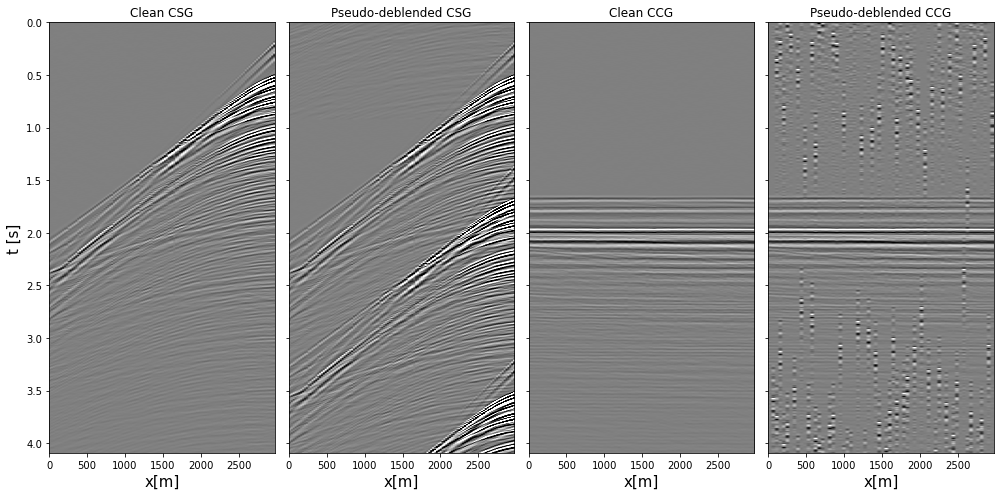

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(14, 7), sharey=True)
axs[0].imshow(data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[0].set_xlabel('x[m]',fontsize=15)
axs[0].set_ylabel('t [s]',fontsize=15)
axs[0].set_title('Clean CSG')
axs[1].imshow(pseudodeblended_data[30, :, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[1].set_xlabel('x[m]',fontsize=15)
axs[1].set_title('Pseudo-deblended CSG')
axs[2].imshow(data[:, 30, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[2].set_xlabel('x[m]',fontsize=15)
axs[2].set_title('Clean CCG')
axs[3].imshow(pseudodeblended_data[:, 30, :].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
              extent=(xr.min(), xr.max(), t.max(), t.min()))
axs[3].set_xlabel('x[m]',fontsize=15)
axs[3].set_title('Pseudo-deblended CCG')
plt.tight_layout()

## Deblending by inversion

We are now ready to solve the deblending problem. The entire procedure is executed inside the `plug_n_play` routine

In [8]:
t0=time.time()
deblended_data_x, deblended_data_y, network_out, error_x, error_y = \
    plug_n_play(BlendingOp, blended_data.ravel(), shapes=(ns, nr, nt), eps=1e0, outer_its=20, 
                inner_its=3, denoiser_epochs=30, initial_network=None, x_true=data.ravel(), device=device)
deblended_data_x = deblended_data_x.reshape(ns, nr, nt)
deblended_data_y = deblended_data_y.reshape(ns, nr, nt)
print(f'Elapsed Time: {(time.time() - t0)/60} min)')

Outer iteration:  0
0.7474556219700202
0.6889848927499407
Outer iteration:  1
0.37928885095296627
0.38263372234237175
Outer iteration:  2
0.21395727170143353
0.18303386851839856
Outer iteration:  3
0.18543917862648857
0.14786602678995148
Outer iteration:  4
0.17040910677807547
0.13165274044332692
Outer iteration:  5
0.14567685474488265
0.11611949076932393
Outer iteration:  6
0.12828296153572488
0.09968911001058922
Outer iteration:  7
0.10620728538354902
0.09122095010441976
Outer iteration:  8
0.0991938970635768
0.08542799802346156
Outer iteration:  9
0.09494612856728296
0.0792916324285991
Outer iteration:  10
0.08929270867008247
0.08044913920846157
Outer iteration:  11
0.0946702069668805
0.0755676237150148
Outer iteration:  12
0.08481779590530213
0.07340241337375397
Outer iteration:  13
0.08193248652830096
0.07201187550792891
Outer iteration:  14
0.08024939666019304
0.07069089628567278
Outer iteration:  15
0.0781132359382312
0.07093400773342799
Outer iteration:  16
0.07909355152760476


Finally we display the error as function of iterations and the solutions for a number of sources and receivers

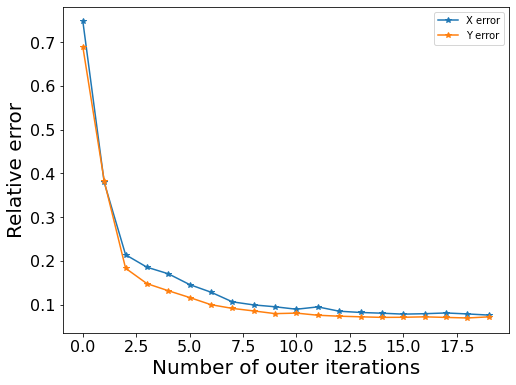

In [18]:
plt.figure(figsize=(8,6))
plt.plot(error_x, '*-', label='X error')
plt.plot(error_y, '*-', label='Y error')
plt.xlabel('Number of outer iterations', fontsize=20)
plt.ylabel('Relative error', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend();

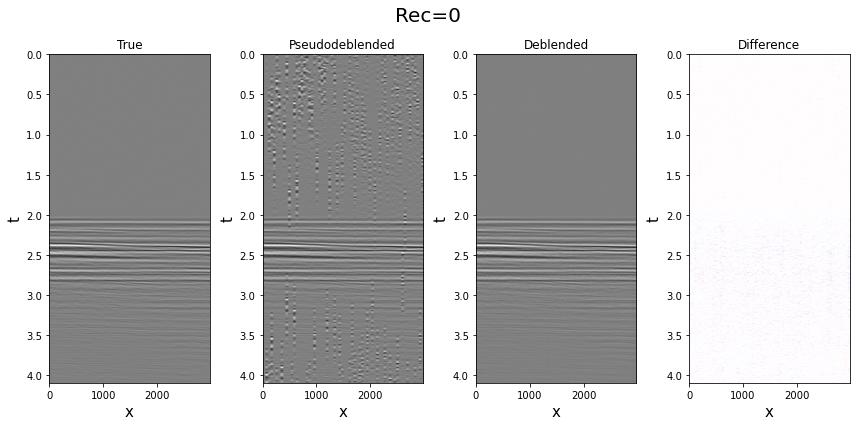

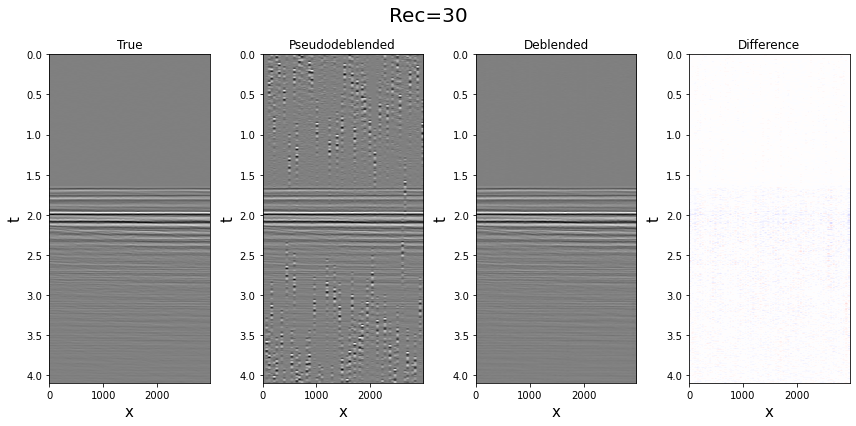

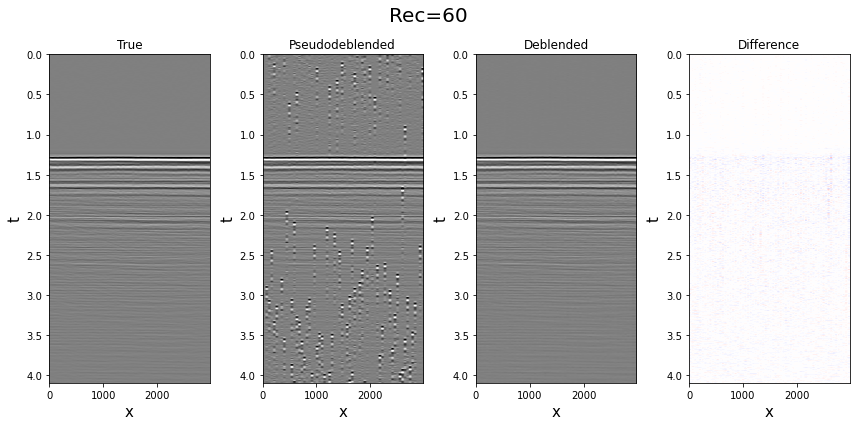

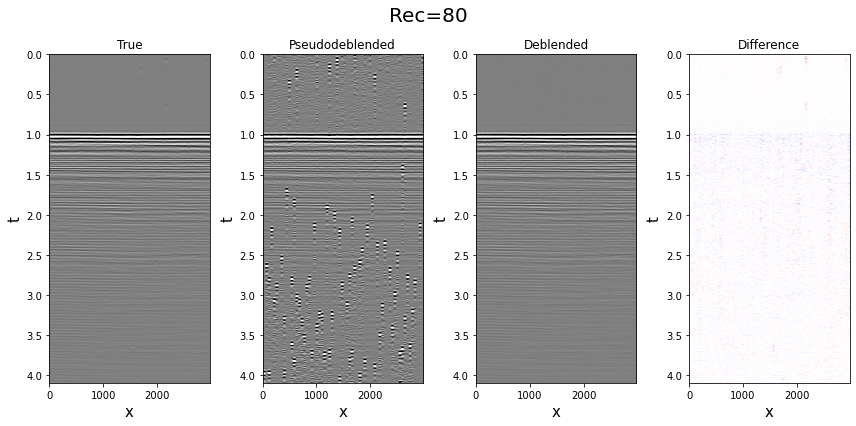

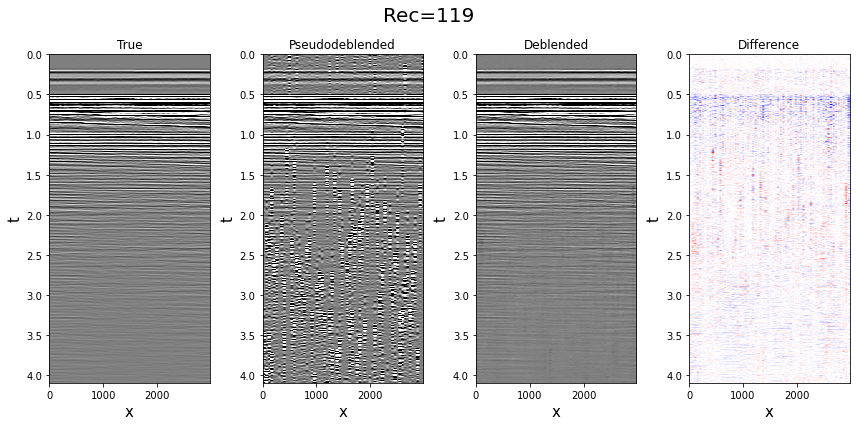

In [10]:
idxs = [0, nr//4, nr//2, 2*nr//3, nr-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Rec={idx}',fontsize=20)
    axs[0].imshow(data[:, idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data_rearranged[idx, :, :].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(deblended_data_x[:, idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Deblended')
    axs[3].imshow((data[:, idx] - deblended_data_x[:, idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

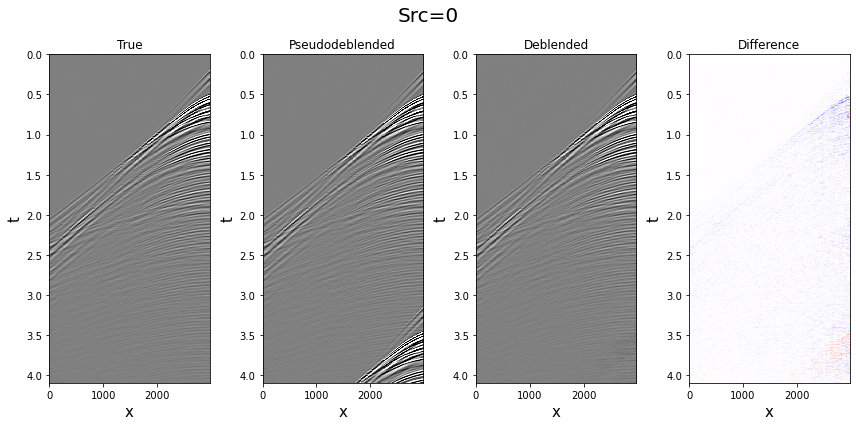

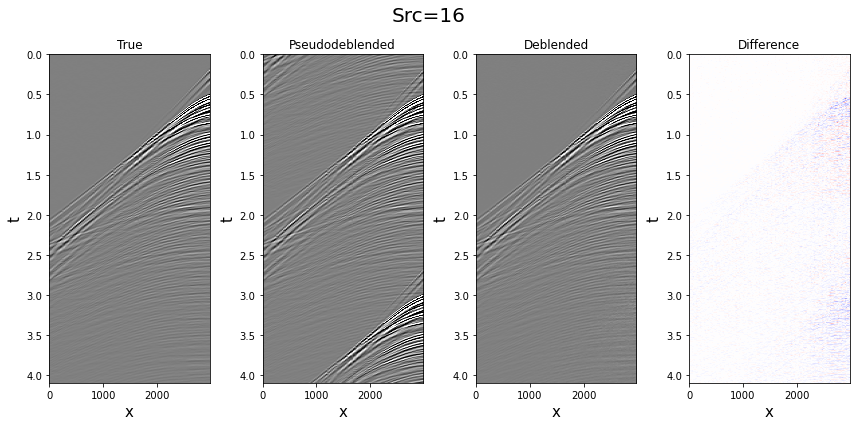

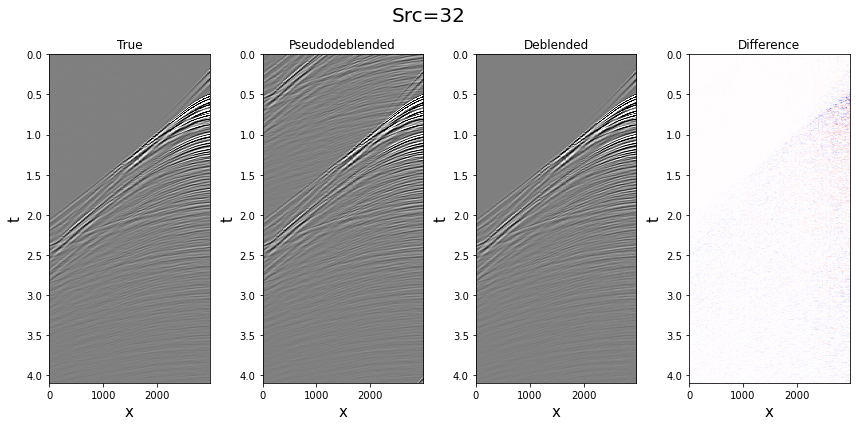

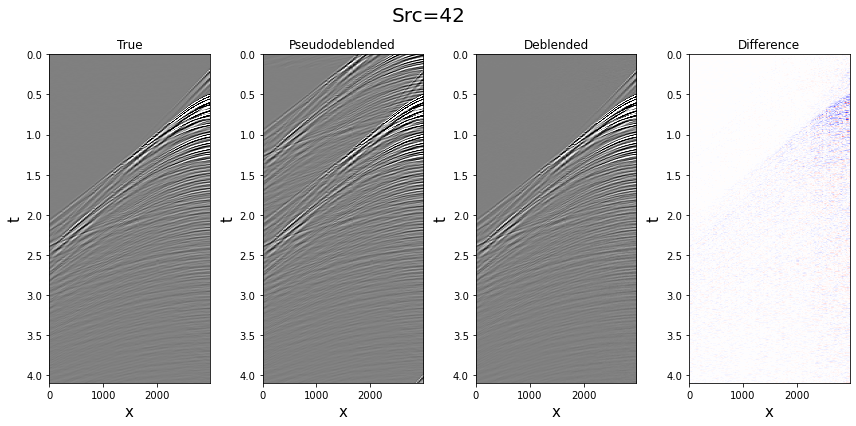

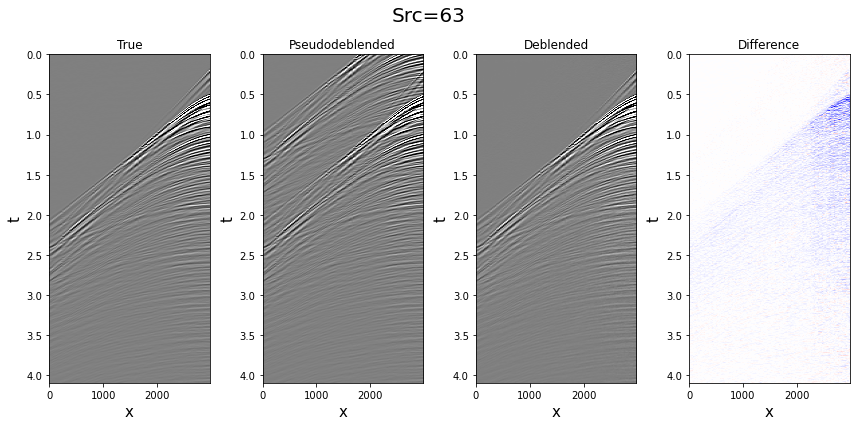

In [15]:
idxs = [0, ns//4, ns//2, 2*ns//3, ns-1]

for idx in idxs:
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle(f'Src={idx}',fontsize=20)
    axs[0].imshow(data[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray', 
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[0].set_xlabel('x',fontsize=15)
    axs[0].set_ylabel('t',fontsize=15)
    axs[0].set_title('True')
    axs[1].imshow(pseudodeblended_data_rearranged[:, idx].T.real, aspect='auto', 
                  vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[1].set_xlabel('x',fontsize=15)
    axs[1].set_ylabel('t',fontsize=15)
    axs[1].set_title('Pseudodeblended')
    axs[2].imshow(deblended_data_x[idx].T.real, aspect='auto', vmin=-100, vmax=100, cmap='gray',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[2].set_xlabel('x',fontsize=15)
    axs[2].set_ylabel('t',fontsize=15)
    axs[2].set_title('Deblended')
    axs[3].imshow((data[idx] - deblended_data_x[idx]).T.real, 
                  aspect='auto', vmin=-100, vmax=100, cmap='seismic',
                  extent=(xr.min(), xr.max(), t.max(), t.min()))
    axs[3].set_xlabel('x',fontsize=15)
    axs[3].set_ylabel('t',fontsize=15)
    axs[3].set_title('Difference')
    plt.tight_layout();

Finally we compute the total RMSE of deblending by denoising

In [16]:
error_deblended = np.linalg.norm(deblended_data_x.ravel() - data.ravel()) / np.linalg.norm(data.ravel())
print(f'Total RMSE (X):{error_deblended}')

error_deblended = np.linalg.norm(deblended_data_y.ravel() - data.ravel()) / np.linalg.norm(data.ravel())
print(f'Total RMSE (Y):{error_deblended}')

Total RMSE (X):0.07593300253477536
Total RMSE (Y):0.07186483583727513
